In [8]:
import warnings
warnings.filterwarnings(action='ignore')

import os
import time

import numpy as np
import pandas as pd
import seaborn as sb

from tensorflow.keras.models import Sequential  # class
from tensorflow.keras.models import load_model  # model 사용
from tensorflow.keras.layers import Dense       # 전결합
from tensorflow.keras.layers import Dropout     # 특정 node를 사용안함.
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten

from tensorflow.keras.callbacks import EarlyStopping   # 학습 자동 중지
from tensorflow.keras.callbacks import ModelCheckpoint # 우수한 학습 모델 파일 저장
from tensorflow.keras import regularizers 
from tensorflow.keras.utils import to_categorical   # one-hot 엔코딩

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.datasets import mnist

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split # 학습셋과 테스트셋의 분리 지원
from sklearn.model_selection import StratifiedKFold  # K겹 교차 검증

import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

font_name = font_manager.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name()
# windows 10
# font_name = font_manager.FontProperties(fname="C:/Windows/Fonts/malgunsl.ttf").get_name()
rc('font', family=font_name)           # 맑은 고딕 폰트 지정
plt.rcParams["font.size"] = 12         # 글자 크기
# plt.rcParams["figure.figsize"] = (10, 4) # 10:4의 그래프 비율
plt.rcParams['axes.unicode_minus'] = False  # minus 부호는 unicode 적용시 한글이 깨짐으로 설정

%matplotlib inline  

In [9]:
width=64
height=64

# 훈련용 데이터 생성기
# rescale=1./255: 실수형태로 정규화, 0~1 사이의 값
train_datagen = ImageDataGenerator(rescale=1./255)
 
train_generator = train_datagen.flow_from_directory(
        './train',                   # 파일이 있는 폴더 
        target_size=(width, height), # 훈련데이터 크기
        batch_size=1,                # 이미지 1건씩 처리
        class_mode='categorical')    # 다중분류

# 검증용 데이터 생성기
vali_datagen = ImageDataGenerator(rescale=1./255)
 
vali_generator = vali_datagen.flow_from_directory(
        './validation',
        target_size=(width, height),    
        batch_size=1,
        class_mode='categorical')
# 3 classes: ./train/circle, ./train/rectangle, ./train/triangle

Found 245 images belonging to 7 classes.
Found 70 images belonging to 7 classes.


In [10]:
model = Sequential()
model.add(Conv2D(32, kernel_size = (3, 3), padding='same',
                 input_shape = (width, height, 3), activation='relu'))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
# 25%만 사용, 4개중에 최대값 1개만 다음 레이어로 전달
model.add(MaxPooling2D(pool_size=(2, 2))) 

# model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
# model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2))) # 25%만 사용
# model.add(Dropout(0.25)) # node 25% 사용하지 않음.

model.add(Flatten()) # 3차원 텐서의 형태를 1차원 열방향으로 변경
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.25)) # node 25% 사용하지 않음.

model.add(Dense(7, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', 
                                metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='loss', patience=2)
start = time.time()

hist = model.fit(
    train_generator,
    epochs = 50,
    validation_data = vali_generator, 
    callbacks=[early_stopping])
end = time.time()
print('Runtime: {0:.2f} 초'.format(end-start))
# gpu: 9 초

Train for 245 steps, validate for 70 steps
Epoch 1/50
245/245 [==============================] - 6s 24ms/step - loss: 1.9542 - accuracy: 0.2000 - val_loss: 1.7978 - val_accuracy: 0.3714
Epoch 2/50
245/245 [==============================] - 5s 21ms/step - loss: 1.5334 - accuracy: 0.4571 - val_loss: 1.0796 - val_accuracy: 0.6286
Epoch 3/50
245/245 [==============================] - 5s 22ms/step - loss: 1.0124 - accuracy: 0.6163 - val_loss: 0.8610 - val_accuracy: 0.6429
Epoch 4/50
245/245 [==============================] - 5s 22ms/step - loss: nan - accuracy: 0.2980 - val_loss: nan - val_accuracy: 0.1429
Epoch 5/50
245/245 [==============================] - 5s 22ms/step - loss: nan - accuracy: 0.1429 - val_loss: nan - val_accuracy: 0.1429
Runtime: 27.69 초


In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1048608   
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 7)                

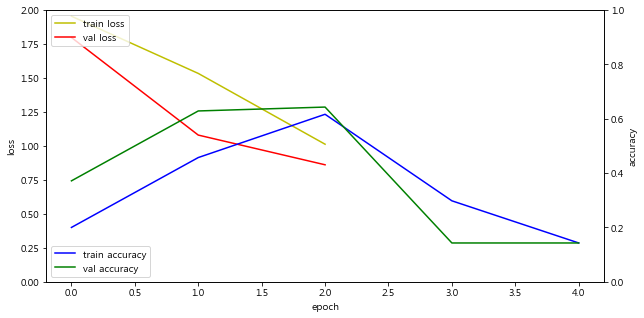

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline  

fig, loss_ax = plt.subplots()
# plt.figure(figsize=(6,4)) # ERROR
fig.set_size_inches(10, 5)  # 챠트 크기 설정

acc_ax = loss_ax.twinx()  # 오른쪽 y 출 설정

# 왼쪽 y 축 설정
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.0, 2.0]) # 값을 반영하여 변경

#오른쪽 y 축 설정
acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val accuracy')
acc_ax.set_ylim([0.0, 1.0])

# 축 레이블 설정
loss_ax.set_xlabel('epoch')  # 학습 횟수
loss_ax.set_ylabel('loss')   # 오차
acc_ax.set_ylabel('accuracy') # 정확도

loss_ax.legend(loc='upper left') # 오차 레이블 위치
acc_ax.legend(loc='lower left')  # 정확도 레이블 위치

plt.show()

In [14]:
print("-- Evaluate --")
scores = model.evaluate_generator(vali_generator, verbose=0)  
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

-- Evaluate --
accuracy: 14.29%


In [15]:
print("-- Predict --")
output = model.predict_generator(vali_generator)
# 실수를 소수점 3자리까지 출력 설정
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
# 그룹의 index {'circle': 0, 'rectangle': 1, 'triangle': 2}, 알파벳 순
print(vali_generator.class_indices) # 분류에 할당된 index
print(type(output))
print(output.shape) # 검증 이미지가 15개, 3개의 분류임으로 출력은 15행 3열
print(output)


-- Predict --
{'Amanda Seyfried': 0, 'Andrew Lincoln': 1, 'Anne Hathaway': 2, 'Hugh Jackman': 3, 'Keira Christina Knightley': 4, 'Pierce Brosnan': 5, 'Zo Jung Seok': 6}
<class 'numpy.ndarray'>
(70, 7)
[[nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan]
 [nan nan nan nan nan na

In [8]:
model.save('Actor.h5')

In [9]:
model = load_model('Actor.h5')

In [16]:
# 테스트용 데이터 생성기
test_datagen = ImageDataGenerator(rescale=1./255)
 
test_generator = test_datagen.flow_from_directory(
        './test1',
        target_size=(width, height),    
        batch_size=1,
        class_mode='categorical')
yp = model.predict_generator(test_generator)
print(yp.shape)
print(yp)
print('타겟: Amanda Seyfried /', display(yp))    # 2차원 텐서 전달

Found 1 images belonging to 1 classes.
(1, 7)
[[nan nan nan nan nan nan nan]]


array([[nan, nan, nan, nan, nan, nan, nan]], dtype=float32)

타겟: Amanda Seyfried / None
